# ML Term Paper - Code: Binary Models 
by Ann-Christin and Sarah 02/03/2021

## 1. Preparation

In [71]:
# import libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.svm import l1_min_c
from time import time
from sklearn import linear_model

from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from tabulate import tabulate


from sklearn import ensemble
from sklearn import tree as tree

# set color theme
sns.set_theme()

#specify your directories
# path = "E:\Data\krea\PIAAC" #enter your path here
path = "C:/Users/gust/Documents/ML_term_paper"
dir_lasso="results/models/" # where the outputs are saved 

#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
os.chdir(path)
print("done")
data = pd.read_csv("data/piaac_red.csv", sep=',', error_bad_lines=False, index_col=False)
data.shape

done


C:\Users\gust\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,4,11,17,22,24,25,28,30,31,38,47,50,57,58,59,62,63,65,68,75,84,85,86,92) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(230691, 129)

In [3]:
# data cleaning, drop variables that have too few observations,are not relevant or collinear
dcl = data.drop(columns = ['Unnamed: 0','inpiaac', "racethn_5cat", "unempflag", "racethn_5cat", "c_q08c2", "seqid", "b_q04b", "b_q19a", 
                         "c_q08c2", "learnatwork", "nfehrsnjr", "nfehrsjr", "nfehrs", "earnmthselfppp", "d_q05b2", 
                          "yrsqual_t", "earnmthbonusppp",  "d_q16d5", "c_q02c", "isco1c", "c_d09", "isic1l", "cnt_h", "isced_hf", "isco1l", "isco1c", "c_d05",
                          'icthome','ictwork','b_q01a','b_q01a_t','yrsqual','ageg10lfs','cnt_brth','fnfaet12jr', 'fe12', 'aetpop', 'faet12', 'faet12jr', 'faet12njr', 
                           'nfe12', 'nfe12jr', 'nfe12njr', 'fnfaet12', 'fnfaet12jr', 'fnfaet12njr']) # exlude those to test the results 
#"isic2l", "isic2c", "isic_cus_c", "isic_lus_c", "isic4_c", "isic4_l",

# further exclude 
dcl = dcl.drop(columns = ['d_q16b', 'b_q20b', 'b_d12h', 'b_q02a_t2', 'b_q11', 'b_q12e', 'd_q12a' , 'b_q04a', 'b_q16', 'b_q26b', 'b_q15c', 'd_q06c', 'b_q15b', 'd_q05a2', 
                          'b_q13', 'b_q15a', 'b_q16', 'b_q02a', 'b_q02a_t1', 'b_q05c', 'b_q10b', 'c_d06', 'd_q04', 'b_q12g', 'b_q12b', 'b_q12d'])


dcl = dcl.loc[:, ~dcl.columns.str.endswith('_c')]
#drop if skill level is missing 
#dcl = dcl[dcl.iscoskil4 != "A"]
#dcl = dcl[dcl.iscoskil4 != "N"]
#dcl = dcl[dcl.iscoskil4 != "U"]

In [4]:
#dcl['d_q05a2'] = dcl['d_q05a2'].astype('object')
dcl['gender_r'] = dcl['gender_r'].astype('category')
dcl["age_r"] = pd.to_numeric(dcl["age_r"])
dcl['b_q12a'] = dcl['b_q12a'].astype('category') # yes/no open educational training
#dcl['b_q12b'] = pd.to_numeric(dcl["b_q12b"]) # number of open/distance educational trainings
#dcl["b_q12d"] = pd.to_numeric(dcl["b_q12d"]) # number of on-the-job training
#dcl['b_q12e'] = dcl['b_q12e'].astype('category')  # yes/no seminars training
dcl['b_q12f'] = pd.to_numeric(dcl["b_q12f"]) # number of seminars
#dcl['b_q12g'] = dcl['b_q12g'].astype('category')  # yes/no private training
dcl['b_q12h'] = pd.to_numeric(dcl["b_q12h"]) # number of private educational trainings
# dcl['j_q03a'] = dcl['j_q03a'].astype('category') # yes/no children
dcl['j_q03b'] = pd.to_numeric(dcl['j_q03b']) # number of children
#dcl['yrsqual_t'] = pd.to_numeric(dcl['yrsqual_t'])
dcl['yrsget'] = pd.to_numeric(dcl['yrsget'])
dcl['iscoskil4'] = dcl['iscoskil4'].astype('category')
#dcl['h_q05g'] = dcl['h_q05g'].astype('category') # Skill use everyday life - ICT - Computer - How often - Programming language  
#dcl['g_q05g'] = dcl['g_q05g'].astype('category') # skill use work - ICT programming lanugage how often
#dcl['g_q05'] = dcl['g_q05'].astype('category') # use computer at work yes/no

In [5]:
cate = dcl.select_dtypes(include=['object', 'category'])
cate = cate.drop(columns = ["iscoskil4"]) 
cate = list(set(cate))
cate

['g_q07',
 'd_q09',
 'g_q05a',
 'd_q13c',
 'g_q08',
 'g_q05h',
 'b_q10a',
 'nopaidworkever',
 'd_q06a',
 'isic1c',
 'g_q05c',
 'g_q05f',
 'cntryid',
 'j_q04a',
 'gender_r',
 'pared',
 'c_q02a',
 'd_q12b',
 'b_q12c',
 'b_q10c',
 'leaver1624',
 'b_q12a',
 'd_q07a',
 'b_q14a',
 'f_q07b',
 'g_q05e',
 'edcat8',
 'b_q26a_t',
 'd_q14',
 'g_q05g',
 'd_q03',
 'd_q04_t',
 'g_q06',
 'b_q14b',
 'vet',
 'b_q01b',
 'd_q12c',
 'g_q05d',
 'g_q04',
 'd_q06b',
 'f_q07a',
 'computerexperience']

In [6]:
# generate dummies                
dummies1 = [pd.get_dummies(dcl[i], prefix=i, drop_first = True) for i in [cate]]
dummies2 =  [pd.get_dummies(dcl["iscoskil4"], prefix="skill")] 
dummies1 = dummies1.pop(0)
dummies1

,g_q07_Yes,d_q09_A temporary employment agency contract,d_q09_An apprenticeship or other training scheme,d_q09_An indefinite contract,d_q09_No contract,d_q09_Other,g_q05a_Every day,g_q05a_Less than once a month,g_q05a_Less than once a week but at least once a month,g_q05a_Never,...,d_q12c_None,g_q05d_Every day,g_q05d_Less than once a month,g_q05d_Less than once a week but at least once a month,g_q05d_Never,g_q04_Yes,d_q06b_Increased,d_q06b_Stayed more or less the same,f_q07a_Yes,computerexperience_Yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,1,0,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,1
4,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230686,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,1,1,0,1,1,1
230687,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,1
230688,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,1,1,1,0,1,1
230689,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,1,1


In [7]:
# generate dummies                
dummies1 = [pd.get_dummies(dcl[i], prefix=i, drop_first = True) for i in [cate]]
dummies2 =  [pd.get_dummies(dcl["iscoskil4"], prefix="skill")] 
dummies1 = dummies1.pop(0)
dummies1 = pd.DataFrame(dummies1)
dummies2 = dummies2.pop(0)
dummies2 = pd.DataFrame(dummies2)
dummies = dummies1.join(dummies2)
dummies = dummies.drop(columns = ["skill_4","skill_U", "skill_A", "skill_N"])
dummies.head()
dummies.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Columns: 182 entries, g_q07_Yes to skill_3
dtypes: uint8(182)
memory usage: 40.0 MB


In [8]:
num = dcl.select_dtypes(include=['float64', "int32"])
num = num.loc[:, ~num.columns.str.startswith('b_q12')]

In [9]:
num.head()
num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   age_r          166949 non-null  float64
 1   j_q03b         103091 non-null  float64
 2   yrsget         125736 non-null  float64
 3   c_q09          160575 non-null  float64
 4   c_q10a         147420 non-null  float64
 5   readytolearn   226734 non-null  float64
 6   earnmthallppp  88508 non-null   float64
dtypes: float64(7)
memory usage: 12.3 MB


In [10]:
num_list = list(set(num))
num_list

['j_q03b',
 'earnmthallppp',
 'yrsget',
 'readytolearn',
 'c_q09',
 'age_r',
 'c_q10a']

In [11]:
# define X and y
on_job = dummies["b_q12c_Yes"] #define y here
open_educ = dummies["b_q12a_Yes"]
X = num.join(dummies)
X = pd.DataFrame(np.ascontiguousarray(X.values), columns = X.columns)
X = X.drop(columns = ["b_q12c_Yes", "b_q12a_Yes"])
y = pd.DataFrame(dict(on_job=on_job, open_educ =open_educ))
y_X = y.join(X)
y_X

,on_job,open_educ,age_r,j_q03b,yrsget,c_q09,c_q10a,readytolearn,earnmthallppp,g_q07_Yes,...,g_q05d_Less than once a week but at least once a month,g_q05d_Never,g_q04_Yes,d_q06b_Increased,d_q06b_Stayed more or less the same,f_q07a_Yes,computerexperience_Yes,skill_1,skill_2,skill_3
0,0,0,NaN,NaN,NaN,NaN,NaN,1.016017,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,1,NaN,NaN,19.0,NaN,NaN,2.164922,NaN,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
2,0,0,NaN,NaN,NaN,NaN,NaN,1.177736,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,0,NaN,NaN,NaN,NaN,NaN,2.112932,NaN,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0,1,NaN,NaN,NaN,NaN,NaN,3.064464,NaN,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230686,0,0,NaN,NaN,8.0,NaN,NaN,1.177736,NaN,1.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
230687,0,0,NaN,NaN,11.0,NaN,NaN,2.156445,NaN,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
230688,1,0,NaN,NaN,11.0,NaN,NaN,2.383062,NaN,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
230689,0,0,NaN,NaN,12.0,NaN,NaN,1.751830,NaN,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


## 2. Logit

### 2.1 Logit 'on_job'

In [12]:
import statsmodels.api as sm 

nona = y_X.drop(columns = ["open_educ","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["on_job"]
X = nona.iloc[:, 1:]


In [13]:
X

,age_r,j_q03b,yrsget,c_q09,c_q10a,readytolearn,earnmthallppp,g_q07_Yes,d_q09_A temporary employment agency contract,d_q09_An apprenticeship or other training scheme,...,g_q05d_Less than once a week but at least once a month,g_q05d_Never,g_q04_Yes,d_q06b_Increased,d_q06b_Stayed more or less the same,f_q07a_Yes,computerexperience_Yes,skill_1,skill_2,skill_3
18418,33.0,2.0,11.0,6.0,1.0,2.361800,2500.0000,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
18423,43.0,1.0,11.0,24.0,1.0,1.124230,1343.1400,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
18433,53.0,2.0,9.0,27.0,2.0,0.788280,980.3900,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
18434,42.0,1.0,11.0,18.0,1.0,1.470600,1314.2200,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
18439,50.0,1.0,11.0,29.0,1.0,0.664940,1460.7800,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225548,43.0,2.0,15.0,23.0,1.0,1.239026,6153.8480,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
225552,42.0,2.0,12.0,22.0,1.0,1.177736,3509.6165,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
225554,24.0,1.0,12.0,6.0,15.0,2.004488,2500.0007,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
225555,51.0,3.0,8.0,35.0,2.0,1.002733,929.0080,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [14]:
logit_model=sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


                                                            Results: Logit
Model:                                       Logit                                    Pseudo R-squared:                         inf   
Dependent Variable:                          on_job                                   AIC:                                      inf   
Date:                                        2021-03-04 14:42                         BIC:                                      inf   
No. Observations:                            40950                                    Log-Likelihood:                           -inf  
Df Model:                                    160                                      LL-Null:                                  0.0000
Df Residuals:                                40789                                    LLR p-value:                              1.0000
Converged:                                   1.0000                                   Scale:                       

## 2.2 Logit 'off job'

In [15]:
import statsmodels.api as sm 

nona = y_X.drop(columns = ["on_job","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["open_educ"]
X = nona.iloc[:, 1:]


In [16]:
logit_model=sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 8


C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


                                                            Results: Logit
Model:                                       Logit                                    Pseudo R-squared:                         inf   
Dependent Variable:                          open_educ                                AIC:                                      inf   
Date:                                        2021-03-04 14:42                         BIC:                                      inf   
No. Observations:                            40950                                    Log-Likelihood:                           -inf  
Df Model:                                    160                                      LL-Null:                                  0.0000
Df Residuals:                                40789                                    LLR p-value:                              1.0000
Converged:                                   1.0000                                   Scale:                       

## 3. Logit with Penalty

## 3.1. 'on job training'

In [86]:
nona = y_X.drop(columns = ["open_educ","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["on_job"]
X = nona.iloc[:, 1:]

# Split the data into test and training sets, with 30% of samples being put into the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)



In [87]:
# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the training data and transform
X_train_std = sc.fit_transform(X_train)

# Apply the scaler to the test data
X_test_std = sc.transform(X_test)


In [92]:
# logistic regression with lasso penalty and 5 fold cross validation
model=LogisticRegressionCV(Cs=20,cv=5,penalty='l1',solver='liblinear',refit=True, random_state = 1).fit(X_train,y_train)

In [93]:
coef=model.coef_
len(coef[0]) 
np.savetxt(dir_lasso+"coef_lasso_logit_onjob.txt",coef[0])

In [94]:
# which value of c was selected (penalty)

print(model.C_) 

[0.23357215]


In [ ]:
# regularization path

cs = l1_min_c(X, y, loss='log') * np.logspace(0, 7, 16)


print("Computing regularization path ...")
start = time()
clf = linear_model.LogisticRegression(penalty='l1', solver='liblinear',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True,
                                      intercept_scaling=10000.)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_)
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
#plt.title('Logistic Regression Path')
plt.axis('tight')
plt.savefig('results\plots\lasso_logit_on_job.png', bbox_inches='tight')
plt.show()

In [95]:
# rerun the regression with optmal penalty 
clf = LogisticRegression(penalty='l1', C=0.23357215, solver='liblinear')
logit = clf.fit(X_train, y_train)

print(np.count_nonzero(clf.coef_)) 

y_pred=logit.predict(X_test)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

132


array([[6639,  669],
       [1320, 3657]], dtype=int64)

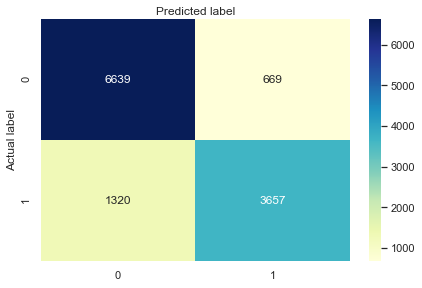

In [96]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
#plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('results\plots\confusion_on_job.png', bbox_inches='tight')

In [97]:
print('Coefficient of each feature:', clf.coef_)
#print('Features:', list(X_train.columns))
print('Training accuracy:', logit.score(X_train_std, y_train))
print('Test accuracy:', clf.score(X_test_std, y_test))
print('') 


Coefficient of each feature: [[-1.41972192e-02  1.42358260e-02 -6.61475765e-04  1.12552621e-02
   5.19978197e-03 -1.81811789e-03 -2.75888041e-07 -6.06829605e-03
   0.00000000e+00  0.00000000e+00  1.53468789e-01 -4.54806153e-01
   1.12322350e-02  9.44896793e-02  0.00000000e+00  0.00000000e+00
  -1.03928109e-01 -9.33799798e-03 -9.69419589e-02 -6.71664844e-02
  -4.22256793e-01 -1.12670055e-01  0.00000000e+00  1.26734123e-01
   0.00000000e+00 -1.73587428e-01  8.69203621e-02  2.88553827e-01
   5.85771673e-01  4.90608089e-01  6.41562999e-01 -1.37498141e-01
   3.57056698e-01 -1.56591699e-01  1.05992362e-01  0.00000000e+00
  -1.74956879e-01 -1.44259792e-01  2.13438551e-01 -4.34804944e-01
  -1.58932764e-01  3.75910569e-01  0.00000000e+00 -2.76325416e-01
   0.00000000e+00  0.00000000e+00  1.51450099e-01  2.05979792e-01
   0.00000000e+00 -6.45773662e-03 -3.81937837e-01  0.00000000e+00
  -9.10760932e-02 -2.46269869e-01  7.48321145e-02  0.00000000e+00
   6.61525130e-02 -1.91333221e-01  0.00000000e+

In [98]:
imp = pd.DataFrame(clf.coef_, index = ["Coefficients"]).T
imp['Feature'] = list(X_train.columns)
imp

,Coefficients,Feature
0,-0.014197,age_r
1,0.014236,j_q03b
2,-0.000661,yrsget
3,0.011255,c_q09
4,0.005200,c_q10a
...,...,...
156,-0.037055,f_q07a_Yes
157,0.000000,computerexperience_Yes
158,0.055590,skill_1
159,0.063122,skill_2


In [99]:
index = imp[(imp['Coefficients'] == 0)].index
imp.drop(index, inplace=True)
imp.reset_index(drop=True, inplace=True)
imp


,Coefficients,Feature
0,-0.014197,age_r
1,0.014236,j_q03b
2,-0.000661,yrsget
3,0.011255,c_q09
4,0.005200,c_q10a
...,...,...
127,-0.170789,d_q06b_Stayed more or less the same
128,-0.037055,f_q07a_Yes
129,0.055590,skill_1
130,0.063122,skill_2


In [100]:
headers = ["Coefficients", "Feature"]
print(tabulate(imp, headers, tablefmt="pipe"))

|     |   Coefficients | Feature                                                                               |
|----:|---------------:|:--------------------------------------------------------------------------------------|
|   0 |   -0.0141972   | age_r                                                                                 |
|   1 |    0.0142358   | j_q03b                                                                                |
|   2 |   -0.000661476 | yrsget                                                                                |
|   3 |    0.0112553   | c_q09                                                                                 |
|   4 |    0.00519978  | c_q10a                                                                                |
|   5 |   -0.00181812  | readytolearn                                                                          |
|   6 |   -2.75888e-07 | earnmthallppp                                                          

In [105]:
imp.sort_values("Coefficients").head(30)

,Coefficients,Feature
79,-2.432663,b_q14a_Yes
54,-1.047331,cntryid_398.0
62,-0.860989,cntryid_Italy
47,-0.829642,cntryid_300.0
60,-0.661661,cntryid_France
49,-0.614480,cntryid_398.0
68,-0.507435,cntryid_Russian Federation
90,-0.461169,edcat8_Tertiary – research degree (ISCED 6)
9,-0.454806,d_q09_No contract
32,-0.434805,isic1c_I


In [106]:
imp.sort_values("Coefficients", ascending = False).head(30)

,Coefficients,Feature
107,4.160427,b_q14b_To obtain a certificate
104,4.098440,b_q14b_To do my job better and/or improve care...
103,3.931989,b_q14b_To be less likely to lose my job
105,3.874899,b_q14b_To increase my knowledge or skills on a...
106,3.573365,b_q14b_To increase my possibilities of getting...
102,3.499309,b_q14b_Other
108,3.478455,b_q14b_To start my own business
58,1.074840,cntryid_Czech Republic
65,0.657386,cntryid_Netherlands
24,0.641563,d_q06a_More than 1000 people


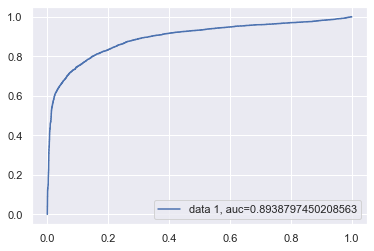

In [47]:
y_pred_proba = logit.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.savefig('results\plots\ROC_on_job.png', bbox_inches='tight')
plt.show()

### 3.2 open education

In [48]:
nona = y_X.drop(columns = ["on_job","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["open_educ"]
X = nona.iloc[:, 1:]

# Split the data into test and training sets, with 30% of samples being put into the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)



In [49]:
# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the training data and transform
X_train_std = sc.fit_transform(X_train)

# Apply the scaler to the test data
X_test_std = sc.transform(X_test)


In [50]:
# logistic regression with lasso penalty and 5 fold cross validation
model=LogisticRegressionCV(Cs=20,cv=5,penalty='l1',solver='liblinear',refit=True, , random_state = 1).fit(X_train,y_train)

In [51]:
coef=model.coef_
len(coef[0]) 
np.savetxt(dir_lasso+"coef_lasso_logit_open.txt",coef[0])

In [52]:
# which value of c was selected (penalty)

print(model.C_) 

[1.62377674]


In [ ]:
# regularization path (takes a lot of time)

cs = l1_min_c(X, y, loss='log') * np.logspace(0, 7, 16)


print("Computing regularization path ...")
start = time()
clf = linear_model.LogisticRegression(penalty='l1', solver='liblinear',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True,
                                      intercept_scaling=10000.)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_)
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
#plt.title('Logistic Regression Path')
plt.axis('tight')
plt.savefig('results\plots\lasso_logit_open_educ.png', bbox_inches='tight')
plt.show()

In [58]:
clf = LogisticRegression(penalty='l1', C=1.62377674, solver='liblinear')
logit = clf.fit(X_train, y_train)

print(np.count_nonzero(clf.coef_)) 

y_pred=logit.predict(X_test)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

153


array([[10844,   153],
       [ 1058,   230]], dtype=int64)

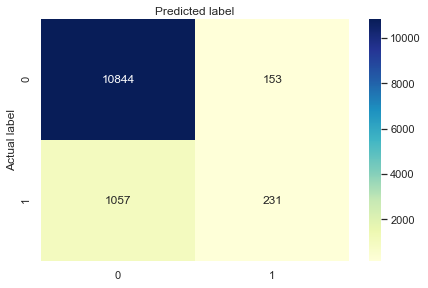

In [54]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
#plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('results\plots\confusion_open_educ.png', bbox_inches='tight')

In [55]:
print('Coefficient of each feature:', clf.coef_)
#print('Features:', list(X_train.columns))
print('Training accuracy:', logit.score(X_train_std, y_train))
print('Test accuracy:', clf.score(X_test_std, y_test))
print('') 



Coefficient of each feature: [[-1.32329570e-02 -7.85903746e-03  1.93212947e-02  1.21255917e-02
   5.07154035e-04  5.45567848e-02  6.32612485e-09  1.76990904e-01
   1.50784263e-01 -9.31528215e-02  1.09574238e-02 -8.95494010e-02
   2.61356456e-01  3.49288501e-02  0.00000000e+00  1.45807033e-01
   4.35245983e-04  3.06658319e-02 -8.90587423e-02 -1.25352575e-01
  -2.55736243e-01 -1.37861151e-01  1.65179835e-02 -4.14309654e-02
  -7.86833898e-02 -3.24033461e-01  7.21866785e-01  9.78226477e-02
   2.16717260e-01  1.79254984e-01  2.43814540e-01 -3.58318047e-01
   1.57361443e-01 -1.87293809e-01  2.47491950e-01  1.34945231e-01
  -1.73938848e-01  2.10851472e-02  3.25984611e-02 -1.11776270e-01
   3.31376293e-02  3.78997917e-01  1.06278512e-01 -3.53052314e-01
   9.31658630e-02  3.57914301e-02  2.03850887e-01  1.04090980e-02
  -5.15299385e-02 -2.83263452e-01 -1.13590941e-01  2.67616893e-01
   4.79743924e-02 -6.28531412e-02 -9.46822795e-02 -1.61928805e-01
   6.07228723e-02  1.90490478e-02 -7.82326780e-

In [78]:
imp = pd.DataFrame(clf.coef_, index = ["Coefficients"]).T
imp['Feature'] = list(X_train.columns)
imp

,Coefficients,Feature
0,-0.013432,age_r
1,-0.007934,j_q03b
2,0.018877,yrsget
3,0.012281,c_q09
4,0.000457,c_q10a
...,...,...
156,0.039371,f_q07a_Yes
157,0.322029,computerexperience_Yes
158,0.009693,skill_1
159,0.013264,skill_2


In [80]:
index = imp[(imp['Coefficients'] == 0)].index
imp.drop(index, inplace=True)
imp.reset_index(drop=True, inplace=True)
imp


,Coefficients,Feature
0,-0.013432,age_r
1,-0.007934,j_q03b
2,0.018877,yrsget
3,0.012281,c_q09
4,0.000457,c_q10a
...,...,...
148,0.039371,f_q07a_Yes
149,0.322029,computerexperience_Yes
150,0.009693,skill_1
151,0.013264,skill_2


In [85]:
headers = ["Coefficients", "Feature"]
print(tabulate(imp, headers, tablefmt="pipe"))

|     |   Coefficients | Feature                                                                               |
|----:|---------------:|:--------------------------------------------------------------------------------------|
|   0 |   -0.0134318   | age_r                                                                                 |
|   1 |   -0.00793444  | j_q03b                                                                                |
|   2 |    0.0188773   | yrsget                                                                                |
|   3 |    0.0122814   | c_q09                                                                                 |
|   4 |    0.000457247 | c_q10a                                                                                |
|   5 |    0.0541885   | readytolearn                                                                          |
|   6 |    6.40219e-09 | earnmthallppp                                                          

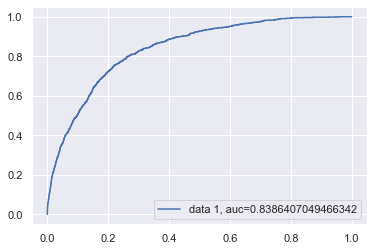

In [57]:
y_pred_proba = logit.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.savefig('results\plots\ROC_open_educ.png', bbox_inches='tight')
plt.show()